# Getting started

**LiveMIEL+** is configured to run from Google Colab, connecting to a Google Drive folder that contains the project data.


---


Project structure:

```bash
LiveMIEL+/
├── Segmentation_features_extraction_clustering.ipynb
├── python_files/
│   ├── __init__.py
│   ├── bandpass_segmentation.py
│   ├── cropping_single_cell.py                       
│   ├── channel_comparison.py
│   ├── classification.py
│   ├── features_extraction.py
│   ├── features_averaging.py                       
│   ├── PCA_plots.py
│   ├── clustering.py
│   └── utils.py
│
├── nuclei_images/
│   └──  test_data     #<--replace with your own data
├── requirements.txt
└── README.md
```


---

**Connect to Google Drive:**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Libraries import

In [2]:
# Install dependencies
!pip install mahotas

# Import standard libraries
import numpy as np
import pandas as pd
import os
import sys
import warnings
warnings.filterwarnings('ignore')

from skimage import io
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Import custom modules
FOLDERNAME = 'LiveMIEL+/python_files'
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

import bandpass_segmentation as bs
import utils
import cropping_single_cells as csc

import channel_comparison as comparison

import classification
from features_extraction import HaralickFeatures, TAS, \
ZernikeMoments, extract, Preprocess, CenterMass, ChromatinFeatures

from features_averaging import features_averaging

from PCA_plots import \
plot_pca_explained_variance, plot_3d_pca, plot_2d_pca

from clustering import hopkins_statistic, silhouette_analysis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 42.7 MB/s eta 0:00:00


# Nuclei segmentation

**Enter the path to the nuclei images for segmentation:**

In [3]:
dir = './drive/My Drive/LiveMIEL+/nuclei_images/test_data/cell_cycle_study/red/'

lst = os.listdir((dir))
lst.sort()

to store segmentation results *single_nuclei_images* and *saved_info_single_cells* are created inside *LiveMIEL+* directory; structure replicates subdirectories of *nuclei_images* with data for segmentation

```bash
LiveMIEL+/
│   ...
├── nuclei_images/
│   ├── test_data/cell_cycle_study/red/      #<--test_data
│   └── ...
...
├── single_nuclei_images/
│   ├── test_data/cell_cycle_study/red/
│   └── ...
└── saved_info_single_cells/
    ├── test_data/cell_cycle_study/red/
    └── ...
```


---

**Create directories to store segmented images and additional files:**

In [5]:
save_dir_nuclei, save_dir_info = utils.create_result_directories(dir)

Created directory: ./drive/My Drive/LiveMIEL+/single_nuclei_images/test_data/cell_cycle_study/red/
Created directory: ./drive/My Drive/LiveMIEL+/saved_info_single_cells/test_data/cell_cycle_study/red/


## Tuning parameters for segmentation

**Choose image for segmentation parameters tuning:**

In [4]:
image_name = str(input("Enter image name to tunining segmentation parameters on: \n"))

Enter image name to tunining segmentation parameters on: 
mpp8_red_0079.tif


To achieve better segmentation on current set of images you may vary such parameters as:

*   *lowSigm* - to remove noise [5, 12]
*   *highSigm* - to remove background [20, 70]
*   *thresh* - to remove image areas with fluorescence intensity below a specified threshold [0.003, 0.05]
*   *FalsePositBrightness_k* - to delete nuclei with low fluorescence from set of segmeneted nuclei [1.0, 2.5]
*   *MinNucleusArea* - to delete nuclei with area less than *MinNucleusArea* from set of segmeneted nuclei [500-2000]

All value ranges are for images at 20 x or 60 x magnification and 1360 x 1024 pixel resolution and *lowSigm*, *highSigm*, *MinNucleusArea* should be scaled proportionally to the magnification and linear dimensions of the images being examined.

In [5]:
print(os.path.join(dir, image_name))
image = io.imread(os.path.join(dir, image_name))

#tune parameters here for better segmentation performance
image_segm = bs.main(image,
                     lowSigm=5,
                     highSigm=20,
                     coeff=1,
                     thresh=0.005,
                     FalsePositBrightness_k = 1.5, #1.5 - for red, 1.1 - for yellow and blue
                     MinNucleusArea = 700)

jet = cm.get_cmap('jet', 256)
newcolors = jet(np.linspace(0, 1, np.max(image_segm)))
black = np.array([0, 0, 0, 1])
newcolors[:1, :] = black
newcmp = ListedColormap(newcolors)

fig, ax = plt.subplots(1,2, figsize=(50, 20))
ax[0].axis('off')
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original image (in RGB)', fontsize=40)
ax[1].axis('Off')
ax[1].imshow(image_segm, cmap=newcmp)
ax[1].set_title('Segmented and labeled image', fontsize=40)
fig.subplots_adjust(wspace=0.02, hspace=0,
                                top=0.9, bottom=0.05, left=0, right=0.75)

Output hidden; open in https://colab.research.google.com to view.

## Segmentation + cropping images into single cells

Segmentation includes the following steps:

1) **Bandpass segmentation** of the nuclei. Bandpass segmentation is applied as

      [ image * large_gaussian_kernel - coeff x (image * small_gaussian_kernel) ] > thresh,
     
     
where * is the operation of convolution and x - multiplication.

2) **Watershed segmentation** to cut the objects which are "stuck together".

3) **Removing false positives objects** - objects that do not correspond to the nuclei in the raw image.

4) **Removing border objects** - objects which are close to image borders.



---



Segmentation is called with *bs.main()*:
 + *image* to segment

Tunable parameters:
 + *lowSigm* - standard deviation of a small gaussian kernel (to remove noise)
 + *highSigm* - standard deviation of a large gaussian kernel (to remove background)
 + *coeff* - scaling coefficient for the image convolved with the small gaussian kernel
 + *thresh* - intensity threshold, above which the final image will be segmented
 + *FalsePositBrightness_k* - removes objects with intensity below a threshold, calculated as the mean intensity multiplied by this value; use to filter out false positives
 + *MinNucleusArea* - removes objects smaller than the specified area (in pixels²); use to filter out false positives

 True/False parameters (*default - True*):

 while *True* exclude from segmentation masks
 + *removeFalsePosit* - objects with low intensity and small area [*FalsePositBrightness_k*, *MinNucleusArea*]
 + *removeBorderObjects* - objects, which centroids are located closer to the image borders than average object radius in masked image


---

**Supported Image Formats:**
- **Grayscale 8-bit** (single channel intensity)
- **One-channel RGB** (only one channel contains data)
- **Uniform RGB** (all three channels have identical values)


In [9]:
import cropping_single_cells as csc

raw_img_names = np.empty(0)
number_segmented = np.empty(0, dtype=int)
labels = np.empty(0, dtype=int)
coordinates = np.empty((0, 4), dtype=int)

for i, img in enumerate(lst):
    print(os.path.join(dir, img))
    image = io.imread(os.path.join(dir, img))

    #put tuned parameters for segmentation
    image_segm = bs.main(image,
                          lowSigm=5,
                          highSigm=20,
                          coeff=1,
                          thresh=0.005,
                          FalsePositBrightness_k = 1.1,
                          MinNucleusArea = 700)

    crops, num_segm, l, coord = csc.cropping_cells(image_segm, image, save_dir_nuclei, img, save=True)

    raw_img_names = np.append(raw_img_names, img)
    number_segmented = np.append(number_segmented, num_segm)
    labels = np.append(labels, l)
    coordinates = np.append(coordinates, coord, axis=0)

    np.save(os.path.join(save_dir_info, 'raw_img_names.npy'), raw_img_names)
    np.save(os.path.join(save_dir_info, 'number_segmented.npy'), number_segmented)
    np.save(os.path.join(save_dir_info, 'labels.npy'), labels)
    np.save(os.path.join(save_dir_info, 'coordinates.npy'), coordinates)

./drive/My Drive/LiveMIEL+/nuclei_images/test_data/cell_cycle_study/red/mpp8_red_0000.tif
Segmenting cells with Banpass filter High Std 20, Low Std  5
<========== Performing Watershed segmentation ==========>
<========== Removing false positive segmented areas ==========>
<========== Removing close to borders segmented areas ==========>
<======== Started cropping ========>
./drive/My Drive/LiveMIEL+/nuclei_images/test_data/cell_cycle_study/red/mpp8_red_0001.tif
Segmenting cells with Banpass filter High Std 20, Low Std  5
<========== Performing Watershed segmentation ==========>
<========== Removing false positive segmented areas ==========>
<========== Removing close to borders segmented areas ==========>
<======== Started cropping ========>
./drive/My Drive/LiveMIEL+/nuclei_images/test_data/cell_cycle_study/red/mpp8_red_0002.tif
Segmenting cells with Banpass filter High Std 20, Low Std  5
<========== Performing Watershed segmentation ==========>
<========== Removing false positive seg

During segmentation several object parameters are collected and stored in .npy files inside *saved_info_single_cells*:

+ *raw_img_names.npy* - filenames of images which were segmented
+ *number_segmented.npy* - number of objects segmented from each raw image
+ *labels.npy* - instance labels (for single nuclei images) within segmentation mask for each raw image
+ *coordinates.npy* - coordinates of each segmented nuclei (bbox) within raw image

# Channel comparison (optional)

If data includes images of epigenetic patterns within nuclei, along with corresponding images of the same nuclei showing specific markers (e.g., for cell-cycle stage or differentiation) in other channels, you can compare the objects from each channel after segmentation. This comparison is based on their spatial coordinates in the original data.


---


**Add paths to the raw nuclei images for channel comparison, and specify where to save the comparison results.**

Note: The first path should contain images from the main channel with epigenetic pattern information. Other channels will only be used to find intersections between their objects and objects from the main channel.

In [7]:
directories = ['./drive/My Drive/LiveMIEL+/nuclei_images/test_data/cell_cycle_study/red/',
               './drive/My Drive/LiveMIEL+/nuclei_images/test_data/cell_cycle_study/yellow/',
               './drive/My Drive/LiveMIEL+/nuclei_images/test_data/cell_cycle_study/blue/']

save_directory = './drive/My Drive/LiveMIEL+/single_nuclei_images/test_data/cell_cycle_study/compared/yellow_blue/'

For comparison *raw_img_names.npy*, *number_segmented.npy*, *labels.npy* and *coordinates.npy* files from segmentation step are used.

Comparison is called with *comparison.main()*:

+ Loads data from each channel
+ Performs comparison based on coordinate proximity
+ Saves objects in main channel that have matches in other channels


---

**Compare channels and save compared nuclei images:**

In [ ]:
comparison.main(directories, save_directory)

**Identifying Unique vs. Common Objects Across Channels**

When comparing 3 or more channels, you may need to distinguish between objects that appear in all channels versus those found in only specific pairs.

The function *comparison.move_common_files()* isolates objects unique to *source_dir* by excluding those common to *comparison_dir*.

For example, it will extract objects found in:
+ $red \cap yellow$  but not in $red \cap yellow \cap blue$
+ $red \cap blue$  but not in $red \cap yellow \cap blue$

Note: Excluded objects are automatically saved to a backup folder *backup_dir*.

In [ ]:
comparison.move_common_files(
    source_dir='./drive/My Drive/LiveMIEL+/single_nuclei_images/test_data/cell_cycle_study/compared/blue/',
    comparison_dir='./drive/My Drive/LiveMIEL+/single_nuclei_images/test_data/cell_cycle_study/compared/yellow_blue/',
    backup_dir='./drive/My Drive/LiveMIEL+/single_nuclei_images/test_data/cell_cycle_study/compared/backup/'
)

# Collecting features from the segmented images

## Extraction

**Add full paths for the cropped nuclei images:**

Note: each path should include objects of only one class

In [11]:
directories = ['./drive/My Drive/LiveMIEL+/single_nuclei_images/test_data/cell_cycle_study/compared/yellow/', #S
               './drive/My Drive/LiveMIEL+/single_nuclei_images/test_data/cell_cycle_study/compared/blue/', #G1
               './drive/My Drive/LiveMIEL+/single_nuclei_images/test_data/cell_cycle_study/compared/yellow_blue/'] #G2, M

Selected features to use in classification:

+   *Haralick features*

+   *TAS features*
+   *Zernike moments* - if **None**, then radius is calculated automatically
+   *Center of mass* of each nucleus
+   *Chromatin features* - minimum, maximum, mean, and total area of all chromatin dots within nucleus

Additional parameters for feature processing:
+   *feat_num* - the number of features of each selected type
+   *objects_i* - the number of objects to classify in the *i*-th class
+   *object_i_class* - the family name (label) for objects in the *i*-th class


---
**Run the cell and enter desirable labels for nuclei in each directory under investigation:**



In [12]:
features = {'features': [HaralickFeatures(), TAS(), ZernikeMoments(None), CenterMass(), ChromatinFeatures()],
            'feat_num' : [13, 54, 25, 2, 4]}

for i in range(len(directories)):
    obj_key = 'objects_' + str(i)
    obj_value = len(os.listdir(directories[i]))
    class_key = 'object_' + str(i) + '_class'
    class_value = str(input("Object class for \n%s \n" %directories[i]))
    features[obj_key] = obj_value
    features[class_key] = class_value

Object class for 
./drive/My Drive/LiveMIEL+/single_nuclei_images/test_data/cell_cycle_study/compared/yellow/ 
S
Object class for 
./drive/My Drive/LiveMIEL+/single_nuclei_images/test_data/cell_cycle_study/compared/blue/ 
G1
Object class for 
./drive/My Drive/LiveMIEL+/single_nuclei_images/test_data/cell_cycle_study/compared/yellow_blue/ 
G2, M


**Preprocessing options:**

If *preporc_commands = ['meanvar', 'pad']*,  images across all classes are padded to the same size (maximum *x* and *y* sizes of images in set + 10-pixels threshold) and scaled to zero mean and unit variance

+ can be ['meanvar', 'pad'] or one of them, or empty

If *normalize=True* - images are normalized to 0-255 prior to features extraction

If *enhance=True* - image's brightnesses are normalized to common brightness=0.09

In [13]:
preproc_commands = ['meanvar', 'pad']

df, X, y = \
classification.dataCollection(directories, features, preproc_commands, normalize=True, enhance=True)

<========== Calculating standard deviation and mean ==========>
123.89856604523455 81.52057017206899
<========== Calculating padding size ===========>
<========== Extraction of S features ==========>
Extraction started


100%|██████████| 4619/4619 [07:50<00:00,  9.82it/s]


<========== Extraction of G1 features ==========>
Extraction started


100%|██████████| 2309/2309 [03:57<00:00,  9.73it/s]


<========== Extraction of G2, M features ==========>
Extraction started


100%|██████████| 1741/1741 [02:52<00:00, 10.08it/s]


## Averaging (optional)

Prior to further processing features *(X)* could be averaged. Two features averaging modes are available, *default='by_dir'*:

+   *'by_dir'* - average over *N* objects within each directory

+  *'by_image'* - average over objects belonging to the same original image, extracted from filenames

*N* value could be set the same for all directories or individually for each directory in *N_set* list.


---



For consistency *directories* should be the same as used during features_extraction.

In [14]:
from features_averaging import features_averaging
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

**Average feature values over N nuclei within image class:**

Avearaging number N could be set as

+ N - same for all directories (classes)
+ N_set - N is set for each directory in N_set
(order of *N_i* should correspond to order of directories in *directories* list)

In [15]:
N = 50
N_set = [20, 40, 40, 40, 40] #N value for each nuclei class

In [16]:
X_preproc, y_preproc = features_averaging(X_std, y, directories, mode='by_dir',N=N, N_set=False)

**Average feature values over all nuclei within original images:**

In [ ]:
X_preproc, y_preproc = features_averaging(X_std, y, directories, mode='by_image')

## Preprocessing

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(X_preproc)   #<-- X_preproc if averaging, else - X

#PCA

**Dimensionality reduction with Principal Component Analysis (PCA):**

In [18]:
from sklearn.decomposition import PCA
from PCA_plots import \
plot_pca_explained_variance, plot_3d_pca, plot_2d_pca

pca_data = PCA(n_components = 3)
principalComponents = pca_data.fit_transform(X_std)

##Explained variance for PCA

**Check PCA quality using the explained variance ratio for each component.**

*plot_pca_explained_variance()* performs PCA on data *X* and plots explained variance ratios.

Parameters:
+ *X*: Data array (samples x features)
+ *n_components*: Number of principal components to compute
+ *show_components*: number of top components to print explained variance for

For PC 1, the explained variance is: 0.4677
For PC 2, the explained variance is: 0.1772


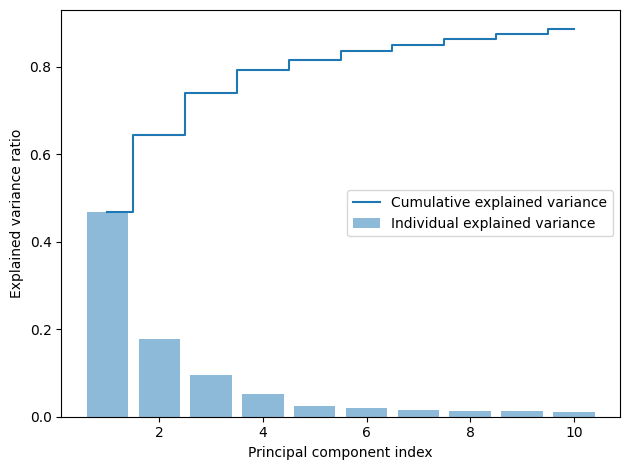

In [ ]:
plot_pca_explained_variance(X_std, n_components=10, show_components=2)

## Plots

Visualisations of reduce feature data

### 3D (interactive)

In [ ]:
plot_3d_pca(X_std, y_preproc, label_name='cell cycle stages', n_components=3, marker_size=5, title='3D PCA')

### 2D

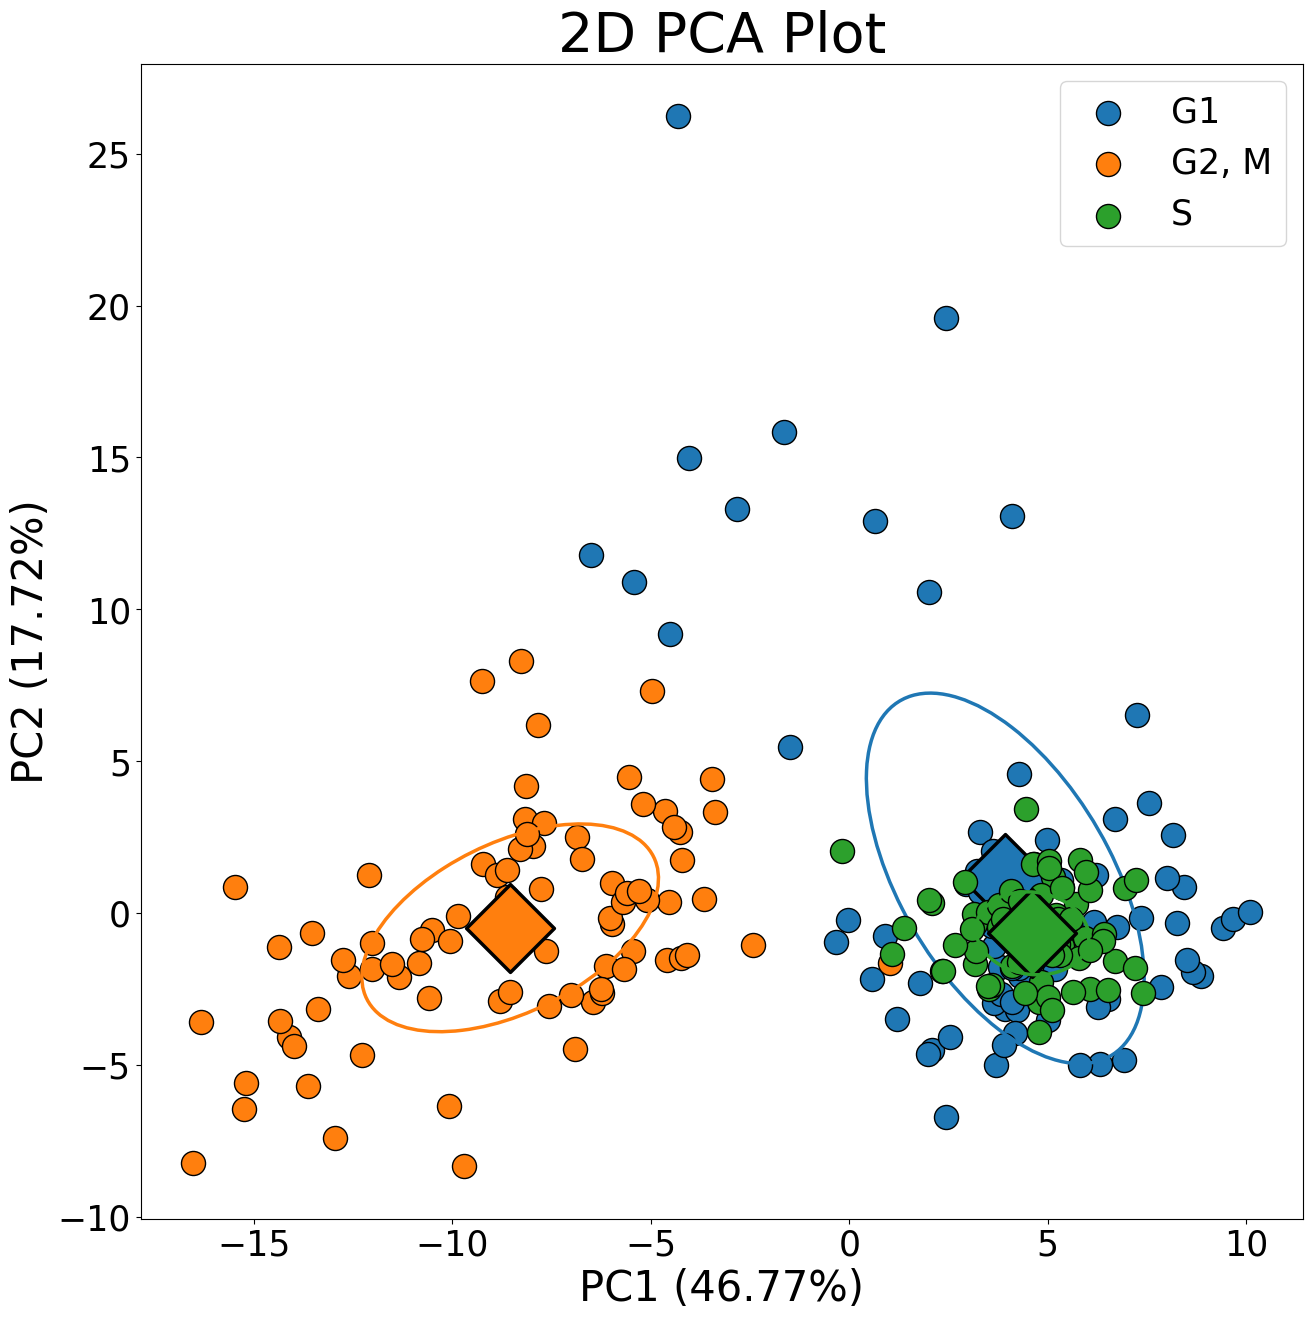

In [ ]:
plot_2d_pca(
    X=X_std,
    labels=y_preproc,
    target_names=None,   #<-- optional; default - unique labels
    colors=None,
    n_components=2,
    ellipse_std=1,   #<-- confidence ellipses, 1 std
    plot_centroids=True,
    save_path=None,   #<-- provide path to save plot
    save_format='svg',
    title='2D PCA Plot',
    figsize=(15, 15),
    fontsize_title=40,
    fontsize_labels=25,
    fontsize_legend=25,
    linewidth=2.5   #<-- line width for centroids and ellipses
)

#Clustering

In [21]:
from clustering import hopkins_statistic, silhouette_analysis

##Hopkins statistics

**Assess clustering tendency using the Hopkins statistic.**

Hopkins statistic $H$:

\begin{align}
        H = \frac{\sum_{i=1}^p u_{i} \, }{\sum_{i=1}^p u_{i} + \sum_{i=1}^p w_{i} }
    \end{align}

$u_{i}$ is the distance from the $i$-th object from the data under investigation to the next closest object from the same data ($p$ objects),

$w_{i}$ is the distance from the $i$-th object to the nearest one in a uniform data distribution of $p$ objects.

*   highly clustered data - $H \approx 0$
*   random data - $H \approx 0.5$
*   uniformly distributed data - $H \approx 1$.


---

Hopkins statistic is called with *hopkins_statistic()*:
+ *X* - the input data matrix
+ *sample_size* - number of samples to use for the test. If *None*, uses min(0.1 * n_samples, 100)
+ *random_state* - random state for reproducible results

In [ ]:
data = principalComponents[:, :2]

n_repeats = 100
hopkins_results = []

for _ in range(n_repeats):
    hopkins_results.append(hopkins_statistic(data))

hopkins_mean = np.mean(hopkins_results)
print(hopkins_mean)

0.13581262365596017


##Silhouette coefficient analysis

**Use silhouette coefficient analysis on PCA data to determine the optimal number of clusters.**

Silhouette coefficients $s$ for each data point range in $[-1, 1]$:
\begin{align}
        s = \frac{b-a}{max(a, b) }
    \end{align}

$a$ is the average distance to objects of the same cluster, $b$ is the average distance to all objects of the next closest cluster.

+  $s \approx 1$ - object located inside cluster
+  $s \approx 0$ - object between 2 clusters (on the border)
+ $s < 0$ - object from clusters $i$ is surrounded by objects from $j$ cluster

The optimal *n_clusters* correspond to:
+ high average silhouette coefficient ($ s_{average}\approx 1$)
+ each cluster has objects with $s > s_{average}$
+ no objects with $s < 0$


---


Silhouette coefficients are visualised for analysis with *silhouette_analysis()*:
+ *X* - data for clustering (n_samples x n_features)
+ *labels* - labels for data (*default=None*),
+ *clustering_method* - clustering method *{None, 'kmeans', 'gmm'}*, *default=None*
+ *n_clusters* - number of clusters for clustering (*default=None*)

if *clustering_method* not *None*
+ *init* - method for initialization *{‘k-means++’, ‘random’}*, (*default='k-means++'*)
+ *n_init* - number of initializations to perform *{‘auto’, int}*, (*default=1*)

### Labeled data

**Analyze silhouette coefficients for actual data labels:**

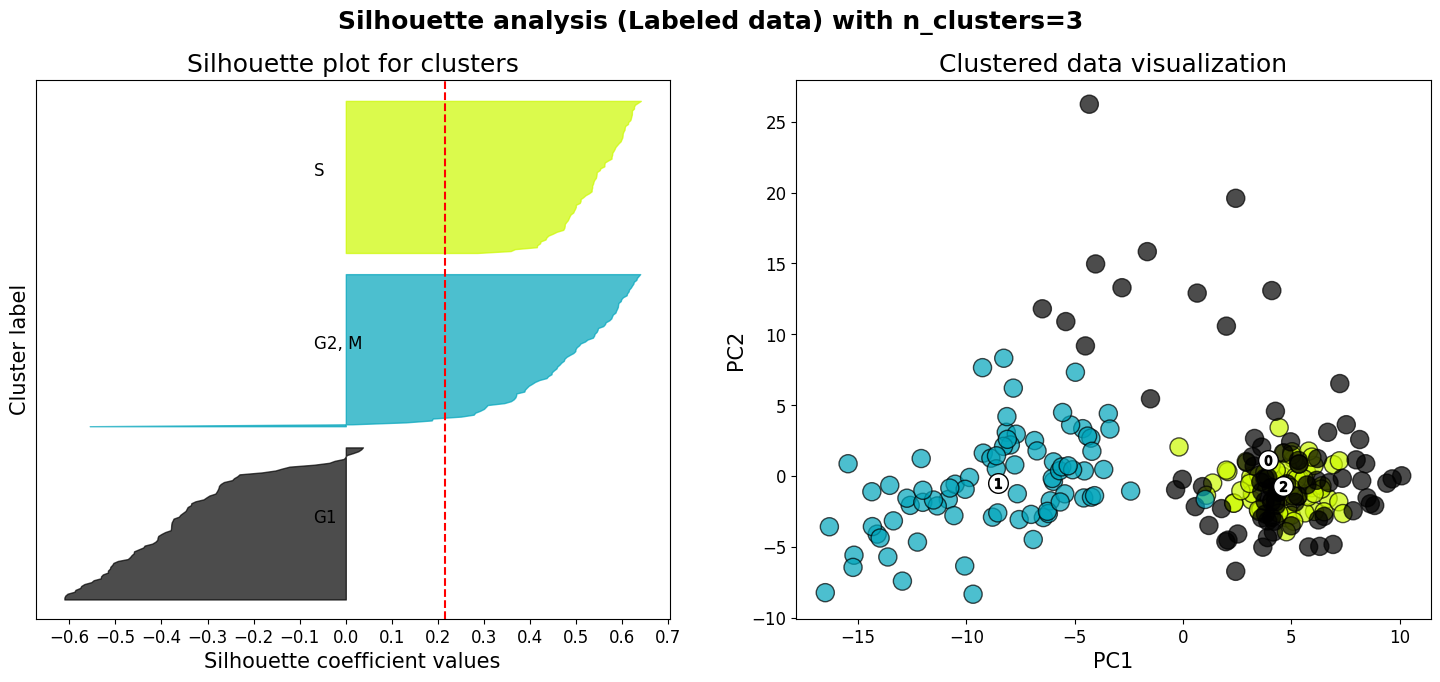

In [ ]:
silhouette_analysis(
    X=principalComponents,
    labels=y_preproc, #cur_dataset['label'],
    clustering_method=None,
    show_plot=True,
    save_path=None,
    save_format='svg',
    fontsize_title=18,
    fontsize_subtitle=18,
    fontsize_axis=15,
    fontsize_labels=12,
    marker_size=170
)

### K-means clustering

**Analyze silhouette coefficients for K-means clustering with n_clusters:**

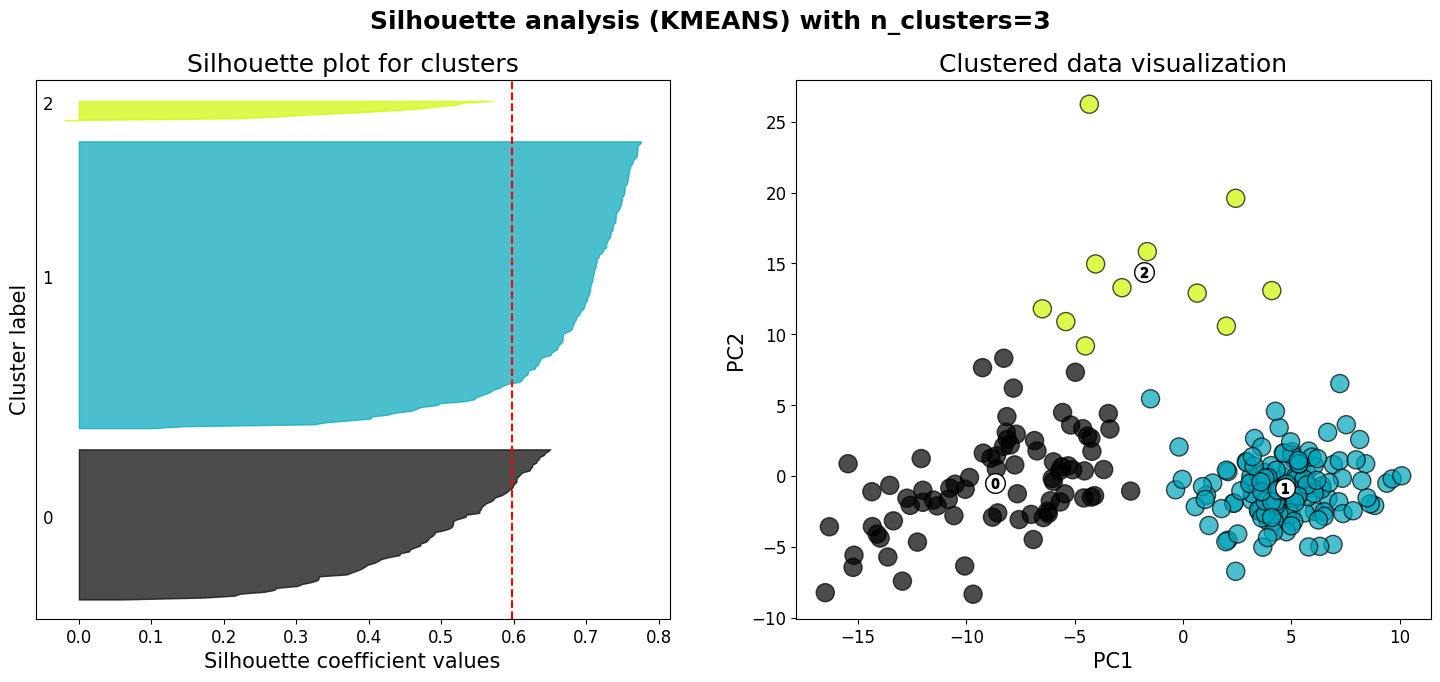

In [ ]:
silhouette_analysis(
    X=principalComponents,
    labels=None,
    clustering_method='kmeans',
    n_clusters=3,
    random_state=10,   #<-- for reproducibility of clustering results
    init = 'k-means++',
    n_init = 1,
    show_plot=True,
    save_path=None,
    save_format='svg',
    fontsize_title=18,
    fontsize_subtitle=18,
    fontsize_axis=15,
    fontsize_labels=12,
    marker_size=170
)

### EM-algorithm clustering

**Analyze silhouette coefficients for EM-clustering with n_clusters:**

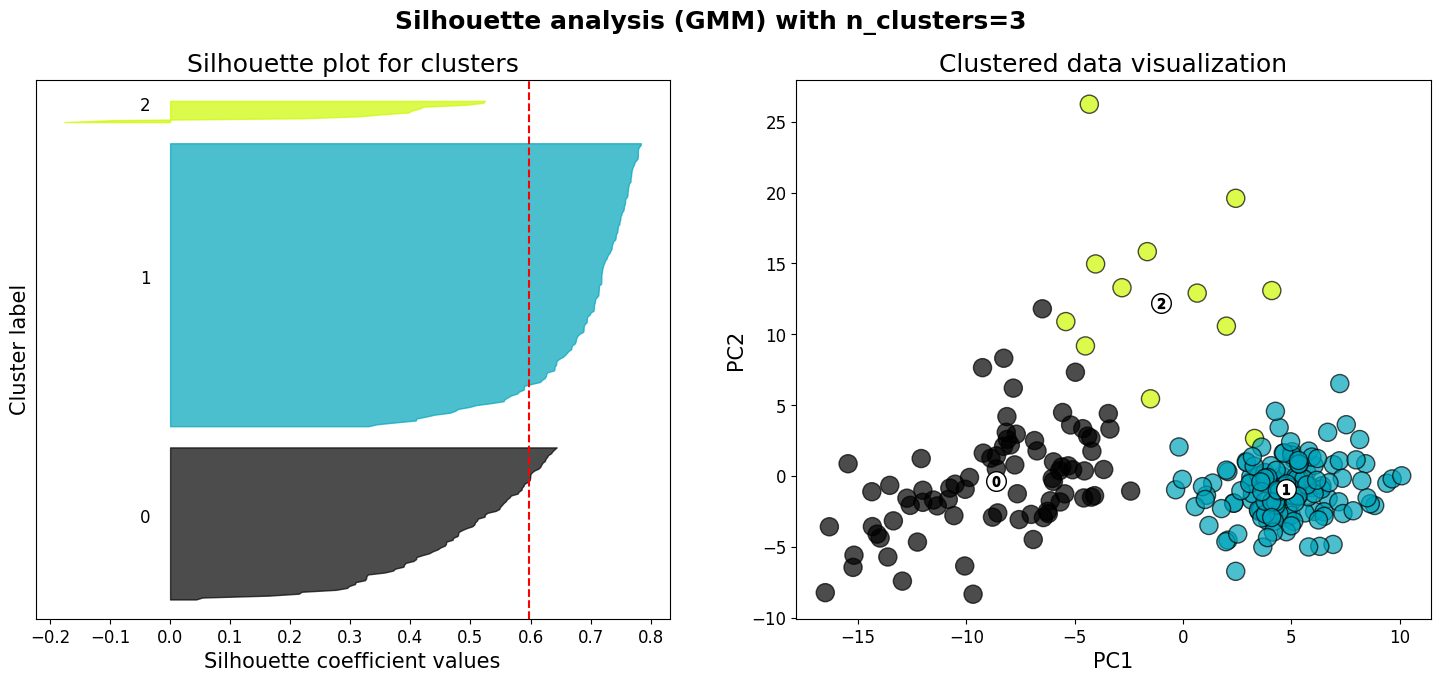

In [ ]:
silhouette_analysis(
    X=principalComponents,
    labels=None,
    clustering_method='gmm',
    n_clusters=3,
    random_state=10,   #<-- for reproducibility of clustering results
    init = 'k-means++',
    n_init = 1,
    show_plot=True,
    save_path=None,
    save_format='svg',
    fontsize_title=18,
    fontsize_subtitle=18,
    fontsize_axis=15,
    fontsize_labels=12,
    marker_size=170
)